In [64]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics

import warnings
warnings.simplefilter('ignore')

In [65]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    """
    The class provides basic functionality for retrieving
    a subset of columns from the dataset.
    """
    
    def __init__(self, feature_names):
        """
        Initialize class instance by setting
        a list of columns to retrieve from the dataset.
        """
        BaseEstimator.__init__(self)
        TransformerMixin.__init__(self)
        self.feature_names = feature_names
        
    def fit(self, X, y=None):
        """
        Fit FeatureSelector to X, but really do nothing.
        Return self.
        """
        return self
    
    def transform(self, X, y=None):
        """
        Transform X using feature selection. 
        Return column-subset of X.
        """
        return X[self.feature_names]

In [77]:
class FeatureGenerator(BaseEstimator, TransformerMixin):
    
    features = {
             'ABS (антиблокировочная система)',
             'AUX/iPod',
             'Bluetooth',
             'CD/MP3 проигрыватель',
             'ESP (система поддержания динамической стабильности)',
             'USB',
             'Автозапуск двигателя',
             'Антипробуксовочная система',
             'Датчик дождя',
             'Иммобилайзер',
             'Камера заднего вида',
             'Климат-контроль',
             'Кондиционер',
             'Контроль мертвых зон на зеркалах',
             'Круиз-контроль',
             'Ксеноновые фары',
             'Легкосплавные диски',
             'Люк',
             'Материал салона - натуральная кожа',
             'Мультимедийный экран',
             'Обогрев зеркал',
             'Обогрев лобового стекла',
             'Обогрев руля',
             'Обогрев сидений',
             'Панорамная крыша',
             'Парктроники',
             'Подушки безопасности боковые',
             'Подушки безопасности задние',
             'Подушки безопасности передние',
             'Противотуманные фары',
             'Рейлинги на крыше',
             'Светодиодные фары',
             'Сигнализация',
             'Системы помощи',
             'Управление мультимедиа с руля',
             'Фаркоп',
             'Штатная навигация',
             'Электрорегулировка сидений',
             'Электростеклоподъемники задние',
             'Электростеклоподъемники передние'}
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        self.add_features(X)
        return X[self.features]
    
    def add_features(self, X):
        for imp in self.features:
            X[imp] = X.table.apply(lambda x: int(imp in x)).astype('int8')

In [78]:
class CatTransformer(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        self.cut(X, ['cuzov', 'fuel'])
        self.to_int(X, 'cost', ' ')
        self.to_int(X, 'volume', ' см3')
        self.fix_run(X)
        self.fix_show(X)
        self.fix_names(X)
        self.fix_region(X)
        self.fix_dates(X)
        X.drop(['table', 'update'], axis=1, inplace=True)
        return X
    
    def cut(self, X, column_names):
        for col in column_names:
            X[col] = X[col].apply(lambda x: x.split()[0])
    
    def to_int(self, X, column_name, phrase):
        X[column_name] = X[column_name].str.replace(phrase, '').astype('int32')
        
    def fix_run(self, X):
        X['run'] = X['run'].str.replace(' км', '')
        miles_mask = X['run'].str.endswith(' миль')
        X.loc[miles_mask, 'run'] = X[miles_mask]['run'].str.replace(' миль', '').astype('int') * 1.60934
        X['run'] = X['run'].astype('int')
        
    def fix_show(self, X):
        X['today_views'] = X['show'].str.extract('\+(.+) ')
        X['show'] = X['show'].str.extract('(.*)' + ' '*25)
        X.rename(columns={'show': 'all_views'}, inplace=True)
        today_view_mask = pd.isna(X['today_views'])
        X.loc[today_view_mask, 'today_views'] = X[today_view_mask]['all_views']
        X['today_views'] = X['today_views'].astype('int')
        X['all_views'] = X['all_views'].astype('int')
        
    def fix_names(self, df):
        two_word_names = ('Alfa Romeo', 'Great Wall', 'Lada (ВАЗ)')
        two_word_names_mask = df['pages'].str.startswith(two_word_names)
        df.loc[two_word_names_mask, 'model'] = (df[two_word_names_mask]['pages'].str.split()
                                                .apply(lambda name: ' '.join(name[2:])))
        df.loc[~two_word_names_mask, 'model'] = (df[~two_word_names_mask]['pages'].str.split()
                                                 .apply(lambda name: ' '.join(name[1:])))
        df.loc[two_word_names_mask, 'pages'] = (df[two_word_names_mask]['pages'].str.split()
                                                .apply(lambda name: ' '.join(name[:2])))
        df.loc[~two_word_names_mask, 'pages'] = (df[~two_word_names_mask]['pages'].str.split()
                                                 .apply(lambda name: ' '.join(name[:1])))
        df['is_restyle'] = df['model'].str.endswith('(рестайлинг)').astype('int8')
        df.rename(columns={'pages': 'brand'}, inplace=True)
        
    def fix_region(self, X):
        
        def _get_region(lst):
            if len(lst) == 1:
                return lst[0]
            return lst[1]
        
        tmp = list(map(lambda s: s.split(', '), X.region))
        X.region = list(map(_get_region, tmp))
        
    def fix_dates(self, df):
        df['date'] = df['update'].apply(lambda x: x.split()[1])
        df['modified'] = df['update'].apply(
            lambda x: int(not x.split()[0] == 'Опубликовано'))
        df['up'] = df['update'].apply(
            lambda x: int(len(x.split()) == 4))

In [79]:
avto = pd.read_csv('full.csv').iloc[:, 1:]
ct = CatTransformer()
avto_tr = ct.fit_transform(avto)

ft = FeatureGenerator()
avto = pd.concat([avto_tr, ft.fit_transform(avto)], axis=1)

In [81]:
avto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11013 entries, 0 to 11012
Data columns (total 59 columns):
color                                                  11013 non-null object
cost                                                   11013 non-null int32
cuzov                                                  11013 non-null object
drive-unit                                             10728 non-null object
fuel                                                   11013 non-null object
brand                                                  11013 non-null object
region                                                 11013 non-null object
run                                                    11013 non-null int64
all_views                                              11013 non-null int64
state                                                  11013 non-null object
transmission                                           11013 non-null object
volume                                         

In [82]:
table = pd.DataFrame(np.zeros((len(FeatureGenerator.features), 2)), 
                     index=FeatureGenerator.features, columns=['diff', 'percent'])
for imp in FeatureGenerator.features:
    a = avto.groupby(by=imp)['cost'].median()
    b = avto[imp].value_counts()
    if 1 in a.index and 0 in a.index:
        table.loc[imp, 'diff'] = a[1] - a[0]
        table.loc[imp, 'percent'] = b[1] / (b.sum())
table = table.sort_values(by='diff')

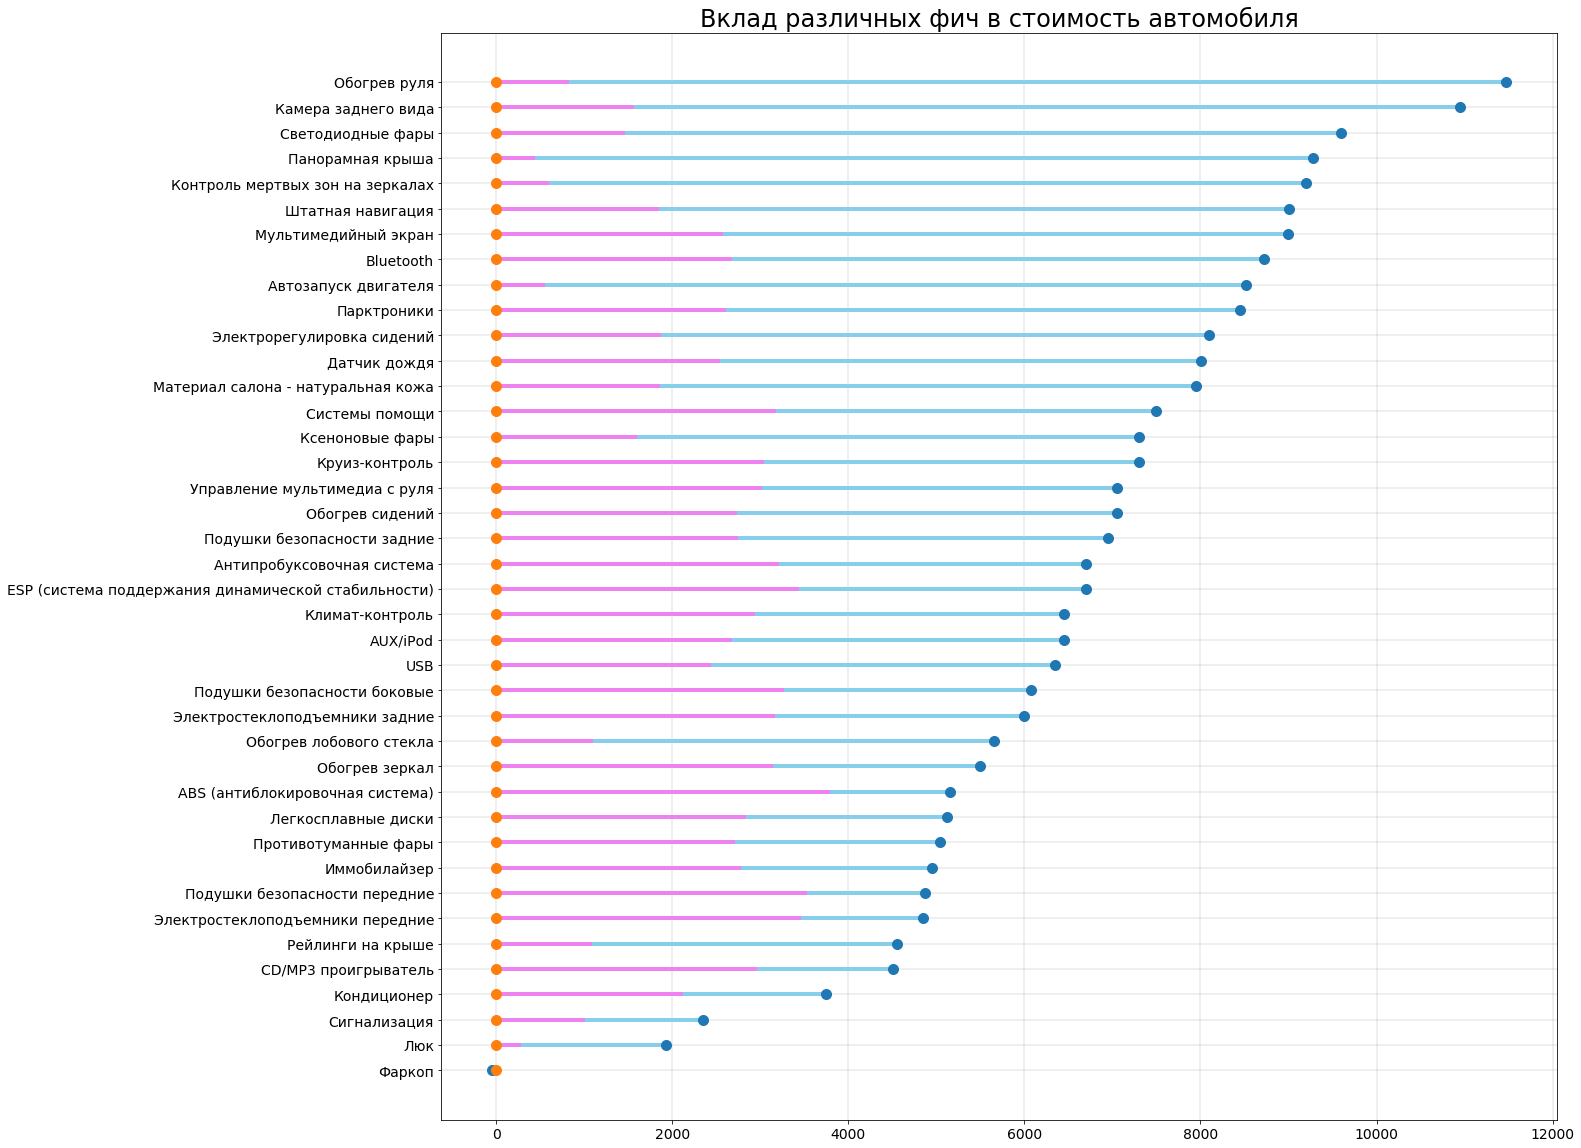

In [83]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20, 20))
plt.hlines(y=table.index, xmin=0, xmax=table['diff'], color='skyblue', linewidth=4)
plt.hlines(y=table.index, xmin=0, xmax=table['diff']*table['percent'], color='violet', linewidth=4)
plt.plot(table, table.index, 'o', markersize=10)
# plt.yticks(my_range, ordered_df.index, size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(linewidth=0.4)
plt.title('Вклад различных фич в стоимость автомобиля', size=24)
plt.show()
